***Import all needed packages***

In [1]:
!pip install ace_tools_open
!pip install ace_tools
import ace_tools_open as tools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances_argmin_min

from sklearn.cluster import SpectralClustering
from sklearn.metrics import pairwise_distances

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.5 MB/s eta 0:00:00


***Import df***

In [2]:
df = pd.read_excel("User_Personas.xlsx")

# print(df.head())

***Drop user_id and user_email***

In the context of clustering or most data analysis tasks, we typically drop columns like user_id and user_email, because it doesn't carry any inherent meaning about the user's behavior or features, thus it is irrelevant for clustering



In [3]:
df = df.drop(["user_id", "user_email"], axis=1)

# print(df.head())

***Update dataset columns to avoid too many dummy variables for better clusterization***

In [4]:
# Update the "country" column based on the given conditions
df['country'] = df['country'].replace({
    'United States': 'North America',
    "Canada" : 'North America',

    'Brazil': 'South America',
    "Chile" : 'South America',
    "Colombia" : 'South America',
    "Mexico" : 'South America',

    "Czech Republic" : "Europe",
    "France" : "Europe",
    "Germany" : "Europe",
    "Gibraltar" : "Europe",
    "Greece": "Europe",
    "Ireland": "Europe",
    "Portugal": "Europe",
    "Spain": "Europe",
    "Ukraine": "Europe",
    "United Kingdom" : "Europe",

    "Philippines" : "Asia",
    "Singapore" : "Asia",

    "Egypt" : "Other",
    "Australia" : 'Other',
    "India" : "Other"
})


# Update the "skin_color" column
df['skin_color'] = df['skin_color'].replace({
    "light" : "light",
    "fair" : "light",

    "tan" : "medium",
    "medium" : "medium",

    "dark" : "dark",
    "other" : "dark"
    })


# Update the "lifestyle" column
df['lifestyle'] = df['lifestyle'].replace({
    "career and business" : "career",

    "family life" : "family",
    "social life" : "family",

    "traveling" : "traveling",

    "fitness and sports" : "sport"
    })


# Update the "climate_zone" column
df['climate_zone'] = df['climate_zone'].replace({
    "cold" : "cold",

    "warm" : "warm",
    "temperate" : "warm",

    "hot" : "hot"
    })


# Update the "style" column
df['style'] = df['style'].replace({
    "casual" : "casual",
    "sporty" : "casual",
    "urban" : "casual",

    "boho" : "creative",
    "creative" : "creative",
    "funky rock" : "creative",
    "preppy" : "creative",

    "sexy" : "elegant",
    "ladylike" : "elegant",
    "classy" : "elegant"
    })


# Update the "occupation" column
df['occupation'] = df['occupation'].replace({
    "remote" : "employed",
    "entrepreneur" : "employed",
    "corporate" : "employed",

    "homemaker" : "unemployed",
    "retired" : "unemployed",

    "other" : "other"
    })


# Update the "goal" column
df['goal'] = df['goal'].replace({
    "align clothes with my body shape" : "comfortability",
    "get comfortable outfits" : "comfortability",

    "dress hot" : "confidence",
    "feel confident" : "confidence",

    "create minimalist wardrobe" : "minimalism"
    })


# Update the "hair_color" column
df['hair_color'] = df['hair_color'].replace({
    "black" : "dark",
    "brown" : "dark",

    "light brown" : "light",
    "blonde" : "light",

    "gray" : "gray",

    "red" : "other",
    "other" : "other"
    })


#Custom mapping for 'budget'
if 'budget' in df.columns:
        budget_map = {
            "less than $200": 0,
            "from $200 to $400": 1,
            "from $400 to $800": 2,
            "more than $800": 3
        }
        df['budget_bin'] = df['budget'].map(budget_map).astype(int)
        df.drop(columns=['budget'], inplace=True)


df.head()

,country,age,eyes_color,hair_color,skin_color,bodyshape,lifestyle,climate_zone,style,occupation,clothing_advice,accessories_advice,goal,height,weight,budget_bin
0,North America,24,blue,light,light,hourglass,traveling,cold,elegant,employed,yes,no,comfortability,171,78,1
1,North America,59,hazel,other,light,triangle,family,warm,elegant,unemployed,yes,yes,confidence,163,73,2
2,North America,22,brown,dark,medium,pear,family,hot,creative,unemployed,yes,yes,minimalism,160,58,3
3,North America,68,hazel,gray,dark,hourglass,family,warm,elegant,unemployed,no,no,comfortability,166,81,3
4,South America,21,hazel,dark,medium,apple,family,warm,elegant,other,yes,no,confidence,171,65,3


***Drop the columns that do not contain any important info for clustering***

`eyes_color` - not valuable for our folloving marketing insights

`hair_color` - not valuable for our folloving marketing insights

`country` - not valuabe, because this attribute can be set directly through the marketing platform (Meta Ads, Google Ads, TikTok Ads, etc.)

`climate_zone` - same reason as for country

`clothing_advice` & `accessories_advice` - not valuable for our folloving marketing insights

`height` - not valuable for our folloving marketing insights



In [5]:
df = df.drop(["eyes_color", "hair_color", "country", "climate_zone", "clothing_advice", "accessories_advice", "height"], axis=1)

# df.head()

***Convert categorial variables to binary***

In [6]:
def convert_text_to_binary(df, columns=None):
    """
    Converts textual categorical columns to numerical
    """
    df = df.copy()

    # --- Select columns to encode ---
    if columns is None:
        columns = df.select_dtypes(include='object').columns.tolist()

    for col in columns:
        if col not in df.columns:
            continue  # already removed, like 'budget'

        unique_vals = df[col].dropna().unique()

        if len(unique_vals) == 2:
            # Binary case
            vals_sorted = sorted(unique_vals)
            mapping = {vals_sorted[0]: 0, vals_sorted[1]: 1}
            df[col + "_bin"] = df[col].map(mapping).astype(int)
        else:
            # Multi-category case
            dummies = pd.get_dummies(df[col], prefix=col)
            df = pd.concat([df, dummies.astype(int)], axis=1)

        df.drop(columns=[col], inplace=True)

    return df

print("Encoded data:")
# print(convert_text_to_binary(df))

df_encoded = convert_text_to_binary(df)
# df_encoded.head()

Encoded data:


In [7]:
df_encoded.dtypes.value_counts()

,count
int64,24


***Scaling***

Scaling is the process of bringing numerical features to a single scale. This is extremely important for many machine learning algorithms, especially clustering.

1) To avoid dominance of large values

2) Because KMeans and other algorithms are distance-based

3) For PCA to work correctly

4) Unification for models that do not normalize themselves

In [8]:
from sklearn.preprocessing import StandardScaler

df_to_scale = df_encoded.copy()
binary_columns = df_to_scale.columns[df_to_scale.nunique() == 2]
scaler = StandardScaler()
df_to_scale[binary_columns] = scaler.fit_transform(df_to_scale[binary_columns])
df_scaled = df_to_scale
# print("Scaled dataset with StandardScaler")
# df_scaled.head()


In [9]:
print("Column names in df_scaled:")
print(list(df_scaled.columns))

Column names in df_scaled:
['age', 'weight', 'budget_bin', 'skin_color_dark', 'skin_color_light', 'skin_color_medium', 'bodyshape_apple', 'bodyshape_hourglass', 'bodyshape_pear', 'bodyshape_rectangle', 'bodyshape_triangle', 'lifestyle_career', 'lifestyle_family', 'lifestyle_sport', 'lifestyle_traveling', 'style_casual', 'style_creative', 'style_elegant', 'occupation_employed', 'occupation_other', 'occupation_unemployed', 'goal_comfortability', 'goal_confidence', 'goal_minimalism']


### **Feature Engineering**

***Silhouette Score***

Clusters df_scaled into k groups

Calculates Silhouette Score (how well the points fit into their clusters)

Shows the result as a number (the closer to 1.0, the better)


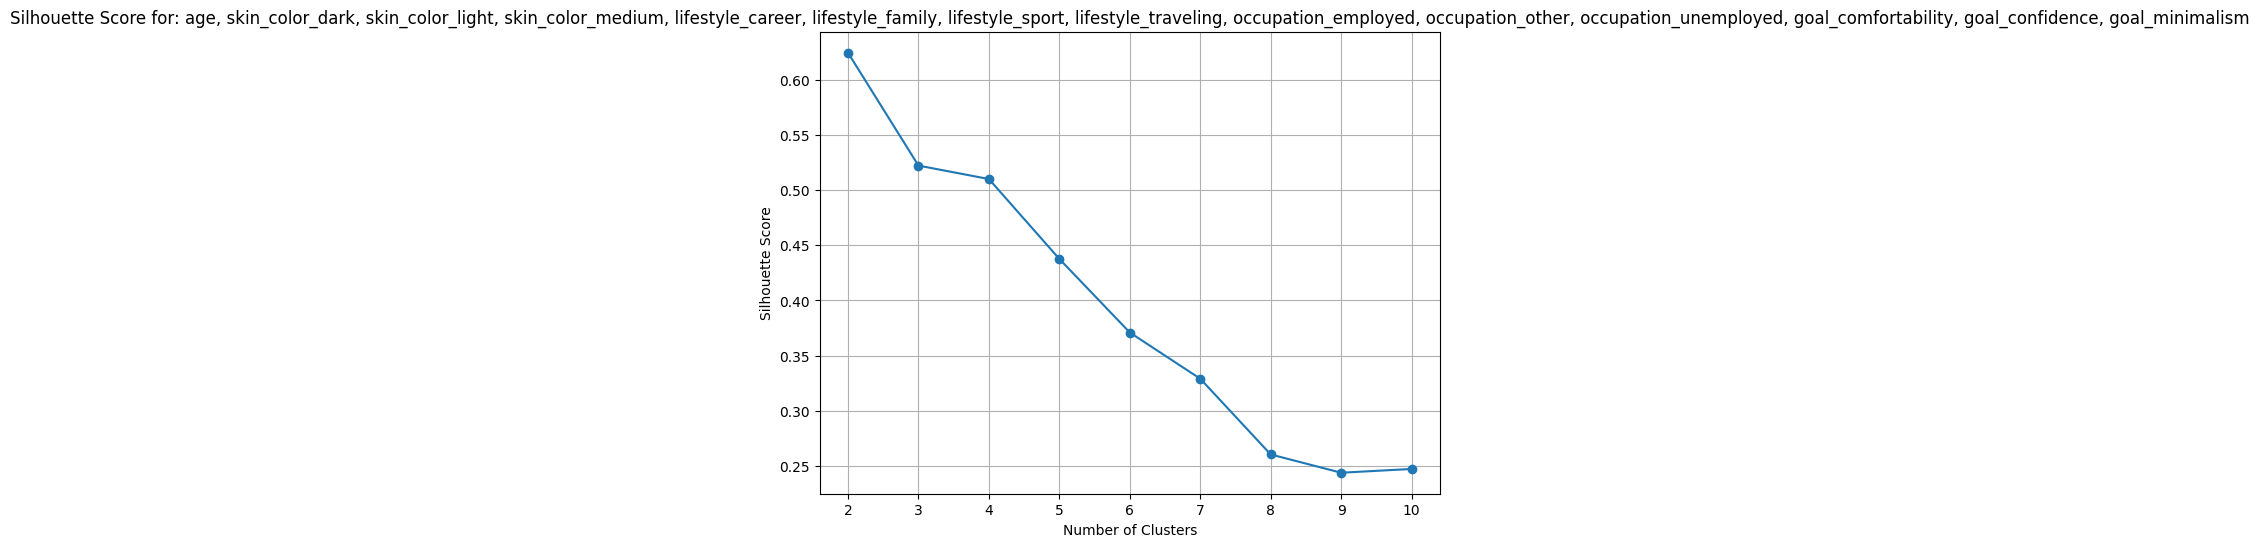

In [10]:
feature_sets = {
    "age_skin color_lifestyle_occupation_goal" : ['age', 'skin_color_dark', 'skin_color_light', 'skin_color_medium', 'lifestyle_career', 'lifestyle_family', 'lifestyle_sport', 'lifestyle_traveling', 'occupation_employed', 'occupation_other', 'occupation_unemployed', 'goal_comfortability', 'goal_confidence', 'goal_minimalism'],
    }

def evaluate_clustering(features, cluster_range=(2, 10)):
    results = []
    X = df_scaled[features]

    for n_clusters in range(cluster_range[0], cluster_range[1] + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        results.append({
            "Feature Set": ", ".join(features),
            "Num Clusters": n_clusters,
            "Silhouette Score": score
        })
    return results

all_results = []
for name, cols in feature_sets.items():
    all_results.extend(evaluate_clustering(cols))

results_df = pd.DataFrame(all_results)

for feature_set in results_df["Feature Set"].unique():
    subset = results_df[results_df["Feature Set"] == feature_set]

    plt.figure(figsize=(8, 6))
    plt.plot(subset["Num Clusters"], subset["Silhouette Score"], marker='o')
    plt.title(f"Silhouette Score for: {feature_set}")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")
    plt.grid(True)
    plt.show()


In [11]:
selected_feature_set = ['age', 'skin_color_dark', 'skin_color_light', 'skin_color_medium', 'lifestyle_career', 'lifestyle_family', 'lifestyle_sport', 'lifestyle_traveling', 'occupation_employed', 'occupation_other', 'occupation_unemployed', 'goal_comfortability', 'goal_confidence', 'goal_minimalism']
new_df = df_scaled[selected_feature_set]

In [12]:
def evaluate_selected_clusters(X, n_clusters_list=[2, 3, 4, 5, 6, 7, 8, 9, 10]):
    results = []
    for n_clusters in n_clusters_list:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        results.append((n_clusters, score))

    for n_clusters, score in results:
        print(f"Number of clusters: {n_clusters}, Silhouette Score: {score:.4f}")


evaluate_selected_clusters(new_df)

Number of clusters: 2, Silhouette Score: 0.6243
Number of clusters: 3, Silhouette Score: 0.5221
Number of clusters: 4, Silhouette Score: 0.5099
Number of clusters: 5, Silhouette Score: 0.4376
Number of clusters: 6, Silhouette Score: 0.3710
Number of clusters: 7, Silhouette Score: 0.3292
Number of clusters: 8, Silhouette Score: 0.2606
Number of clusters: 9, Silhouette Score: 0.2441
Number of clusters: 10, Silhouette Score: 0.2475


***Calinski-Harabasz Index***

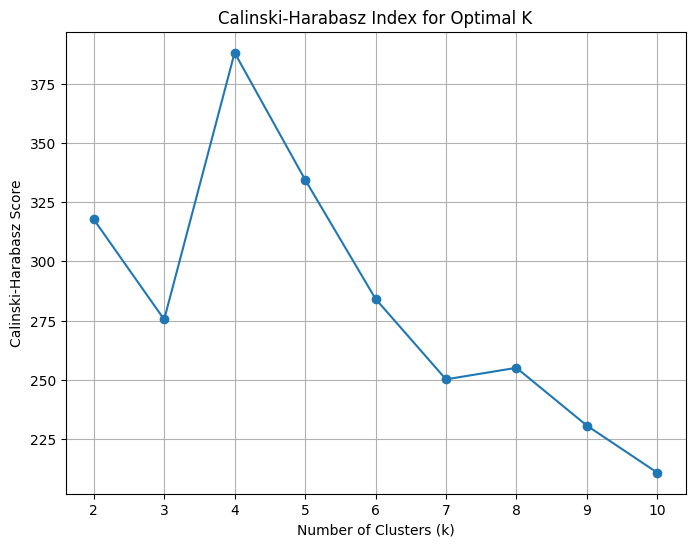

In [13]:
k_range = range(2, 11)
calinski_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(new_df)
    score = calinski_harabasz_score(new_df, kmeans.labels_)
    calinski_scores.append(score)

plt.figure(figsize=(8, 6))
plt.plot(k_range, calinski_scores, marker='o')
plt.title('Calinski-Harabasz Index for Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski-Harabasz Score')
plt.grid(True)
plt.show()


***Elbow method***

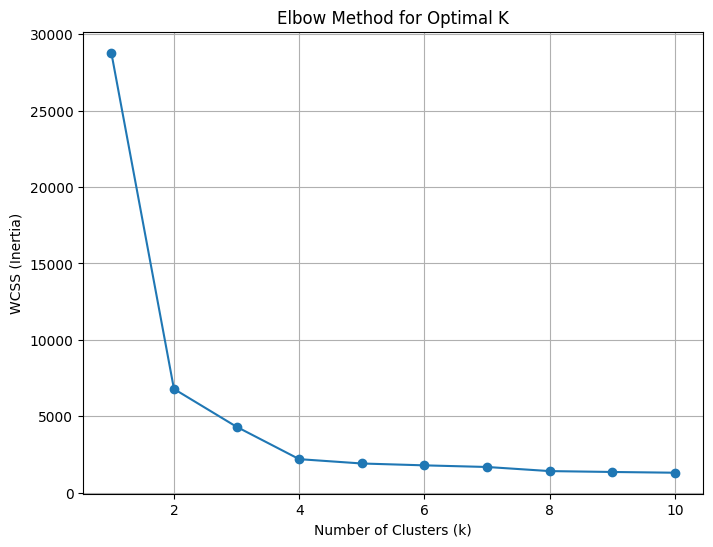

In [14]:
k_range = range(1, 11)
wcss = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(new_df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.grid(True)
plt.show()

### **K-means**

***visualing of 2, 3, and 4 clusters using PCA***

<ipython-input-16-ee943b004b87>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Cluster_2'] = kmeans_2.fit_predict(new_df)
<ipython-input-16-ee943b004b87>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Cluster_3'] = kmeans_3.fit_predict(new_df)
<ipython-input-16-ee943b004b87>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

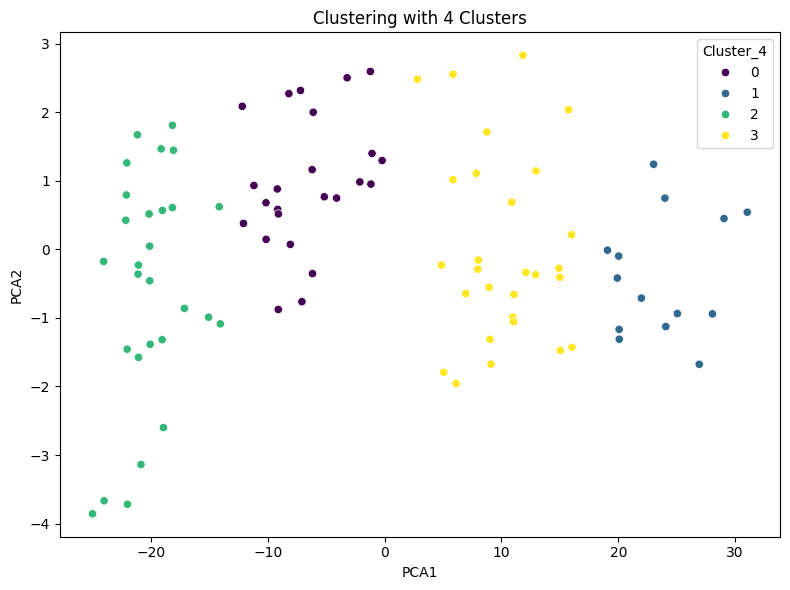

In [16]:
n_clusters_2 = 2
n_clusters_3 = 3
n_clusters_4 = 4

kmeans_2 = KMeans(n_clusters=n_clusters_2, random_state=42)
kmeans_3 = KMeans(n_clusters=n_clusters_3, random_state=42)
kmeans_4 = KMeans(n_clusters=n_clusters_4, random_state=42)

selected_feature_set = ['age', 'skin_color_dark', 'skin_color_light', 'skin_color_medium', 'lifestyle_career', 'lifestyle_family', 'lifestyle_sport', 'lifestyle_traveling', 'occupation_employed', 'occupation_other', 'occupation_unemployed', 'goal_comfortability', 'goal_confidence', 'goal_minimalism']
new_df = df_scaled[selected_feature_set]

new_df['Cluster_2'] = kmeans_2.fit_predict(new_df)
new_df['Cluster_3'] = kmeans_3.fit_predict(new_df)
new_df['Cluster_4'] = kmeans_4.fit_predict(new_df)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(new_df.drop(columns=['Cluster_2', 'Cluster_3', 'Cluster_4']))

pca_df = pd.DataFrame(data=principal_components, columns=['PCA1', 'PCA2'])

plt.figure(figsize=(8, 6))


# plt.subplot(1, 3, 1)
# sns.scatterplot(x='PCA1', y='PCA2', hue=new_df['Cluster_2'], palette='viridis', data=pca_df, legend='full')
# plt.title('Clustering with 2 Clusters')

# plt.subplot(1, 3, 2)
# sns.scatterplot(x='PCA1', y='PCA2', hue=new_df['Cluster_3'], palette='viridis', data=pca_df, legend='full')
# plt.title('Clustering with 3 Clusters')

# plt.subplot(1, 3, 3)
sns.scatterplot(x='PCA1', y='PCA2', hue=new_df['Cluster_4'], palette='viridis', data=pca_df, legend='full')
plt.title('Clustering with 4 Clusters')

plt.tight_layout()
plt.show()


***visualing with TSE***

<ipython-input-17-1fbfa673f5bf>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Cluster_2'] = kmeans_2.fit_predict(new_df)
<ipython-input-17-1fbfa673f5bf>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Cluster_3'] = kmeans_3.fit_predict(new_df)
<ipython-input-17-1fbfa673f5bf>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

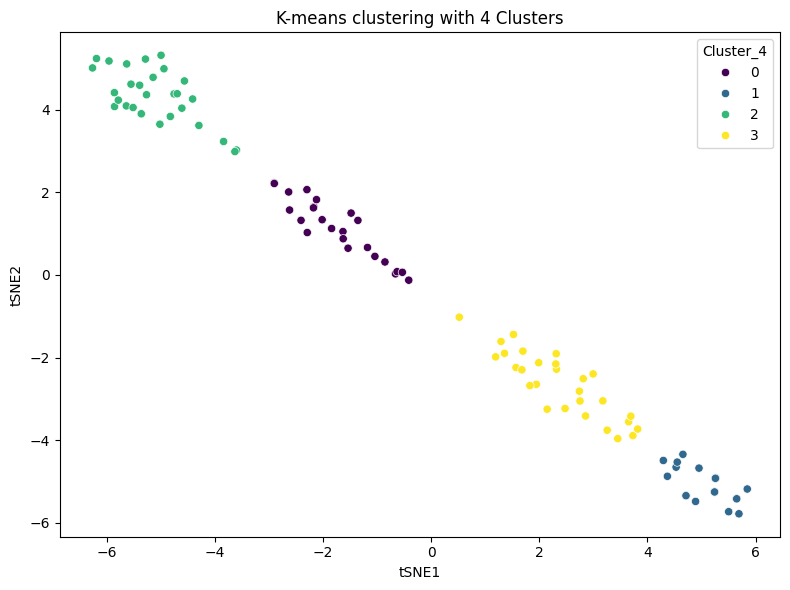

In [17]:
n_clusters_2 = 2
n_clusters_3 = 3
n_clusters_4 = 4

selected_feature_set = ['age', 'skin_color_dark', 'skin_color_light', 'skin_color_medium', 'lifestyle_career', 'lifestyle_family', 'lifestyle_sport', 'lifestyle_traveling', 'occupation_employed', 'occupation_other', 'occupation_unemployed', 'goal_comfortability', 'goal_confidence', 'goal_minimalism']
new_df = df_scaled[selected_feature_set]

kmeans_2 = KMeans(n_clusters=n_clusters_2, random_state=42)
kmeans_3 = KMeans(n_clusters=n_clusters_3, random_state=42)
kmeans_4 = KMeans(n_clusters=n_clusters_4, random_state=42)

new_df['Cluster_2'] = kmeans_2.fit_predict(new_df)
new_df['Cluster_3'] = kmeans_3.fit_predict(new_df)
new_df['Cluster_4'] = kmeans_4.fit_predict(new_df)

tsne = TSNE(n_components=2, random_state=42)
tsne_components = tsne.fit_transform(new_df.drop(columns=['Cluster_2', 'Cluster_3', 'Cluster_4']))  # Drop clusters column for t-SNE

tsne_df = pd.DataFrame(data=tsne_components, columns=['tSNE1', 'tSNE2'])

plt.figure(figsize=(8, 6))

# plt.subplot(1, 3, 1)
# sns.scatterplot(x='tSNE1', y='tSNE2', hue=new_df['Cluster_2'], palette='viridis', data=tsne_df, legend='full')
# plt.title('K-means clustering with 2 Clusters')

# plt.subplot(1, 3, 2)
# sns.scatterplot(x='tSNE1', y='tSNE2', hue=new_df['Cluster_3'], palette='viridis', data=tsne_df, legend='full')
# plt.title('K-means clustering with 3 Clusters')

# plt.subplot(1, 3, 3)
sns.scatterplot(x='tSNE1', y='tSNE2', hue=new_df['Cluster_4'], palette='viridis', data=tsne_df, legend='full')
plt.title('K-means clustering with 4 Clusters')

plt.tight_layout()
plt.show()


***Finding the characteristics of each cluster: min, max, average***

In [18]:
binary_columns = [
    'skin_color_dark', 'skin_color_light', 'skin_color_medium',
    'lifestyle_career', 'lifestyle_family', 'lifestyle_sport', 'lifestyle_traveling',
    'occupation_employed', 'occupation_other', 'occupation_unemployed',
    'goal_comfortability', 'goal_confidence', 'goal_minimalism'
]

mean_std_values = df_encoded[binary_columns].agg(['mean', 'std'])

def unscale(scaled_value, column):
    return scaled_value * mean_std_values.loc['std', column] + mean_std_values.loc['mean', column]

new_df_unscaled = new_df.copy()

for column in binary_columns:
    new_df_unscaled[column] = new_df[column].apply(lambda x: unscale(x, column))

def compute_custom_cluster_stats(df, cluster_col):
    grouped = df.groupby(cluster_col)

    age_stats = grouped['age'].agg(['max', 'min', 'mean', 'median'])
    age_stats.columns = [f"age_{stat}" for stat in age_stats.columns]

    other_features = [col for col in df.columns if col not in ['age', cluster_col]]
    other_means = grouped[other_features].mean()
    other_means.columns = [f"{col}_mean" for col in other_means.columns]

    final_stats = pd.concat([age_stats, other_means], axis=1).reset_index()
    return final_stats

cluster_stats_2 = compute_custom_cluster_stats(new_df_unscaled, 'Cluster_2')
cluster_stats_3 = compute_custom_cluster_stats(new_df_unscaled, 'Cluster_3')
cluster_stats_4 = compute_custom_cluster_stats(new_df_unscaled, 'Cluster_4')

print("\nCluster Characteristics (2 clusters) - Unscaled Data:")
print(tabulate(cluster_stats_2, headers='keys', tablefmt='pretty'))

print("\nCluster Characteristics (3 clusters) - Unscaled Data:")
print(tabulate(cluster_stats_3, headers='keys', tablefmt='pretty'))

print("\nCluster Characteristics (4 clusters) - Unscaled Data:")
print(tabulate(cluster_stats_4, headers='keys', tablefmt='pretty'))



Cluster Characteristics (2 clusters) - Unscaled Data:
+---+-----------+---------+---------+--------------------+------------+----------------------+-----------------------+------------------------+-----------------------+-----------------------+----------------------+--------------------------+--------------------------+-----------------------+----------------------------+--------------------------+----------------------+----------------------+--------------------+--------------------+
|   | Cluster_2 | age_max | age_min |      age_mean      | age_median | skin_color_dark_mean | skin_color_light_mean | skin_color_medium_mean | lifestyle_career_mean | lifestyle_family_mean | lifestyle_sport_mean | lifestyle_traveling_mean | occupation_employed_mean | occupation_other_mean | occupation_unemployed_mean | goal_comfortability_mean | goal_confidence_mean | goal_minimalism_mean |   Cluster_3_mean   |   Cluster_4_mean   |
+---+-----------+---------+---------+--------------------+------------+

### **Agglomerative Hierarchical Clustering**

Before running the *hierarchical clustering* we need to understand what metrics is better to use for our dataset. That is why we will check the silhouette score for hierarchical clustering with both Gower distance and Euclidean distance.

The results showed us that the quality of clustering is better when run on gower distance metrics. This is why we will perform Hierarchical clustering with gower distance in our further work.

In [19]:
selected_feature_set = ['age', 'skin_color_dark', 'skin_color_light', 'skin_color_medium', 'lifestyle_career', 'lifestyle_family', 'lifestyle_sport', 'lifestyle_traveling', 'occupation_employed', 'occupation_other', 'occupation_unemployed', 'goal_comfortability', 'goal_confidence', 'goal_minimalism']
featured_df = df_scaled[selected_feature_set]
# featured_df

In [21]:
!pip install gower
import gower

<ipython-input-22-fe0b0386fb05>:2: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z_gower = linkage(distance_matrix_full, method='ward')


Silhouette Score (Gower distance): 0.29929399490356445
Silhouette Score (Euclidean distance): 0.5131831392487887


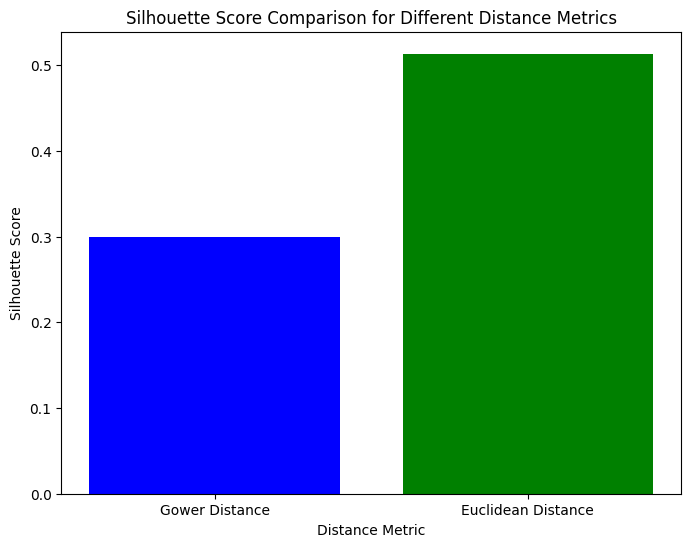

In [22]:
distance_matrix_full = gower.gower_matrix(featured_df)
Z_gower = linkage(distance_matrix_full, method='ward')
num_clusters = 3
labels_gower = fcluster(Z_gower, num_clusters, criterion='maxclust')

silhouette_gower = silhouette_score(distance_matrix_full, labels_gower, metric='precomputed')
print(f"Silhouette Score (Gower distance): {silhouette_gower}")

agg_clustering_euclidean = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')
# Ward's method always uses Euclidean distance to calculate the distances between clusters
labels_euclidean = agg_clustering_euclidean.fit_predict(featured_df)

silhouette_euclidean = silhouette_score(featured_df, labels_euclidean, metric='euclidean')
print(f"Silhouette Score (Euclidean distance): {silhouette_euclidean}")

labels = ['Gower Distance', 'Euclidean Distance']
scores = [silhouette_gower, silhouette_euclidean]

plt.figure(figsize=(8, 6))
plt.bar(labels, scores, color=['blue', 'green'])
plt.title('Silhouette Score Comparison for Different Distance Metrics')
plt.xlabel('Distance Metric')
plt.ylabel('Silhouette Score')
plt.show()


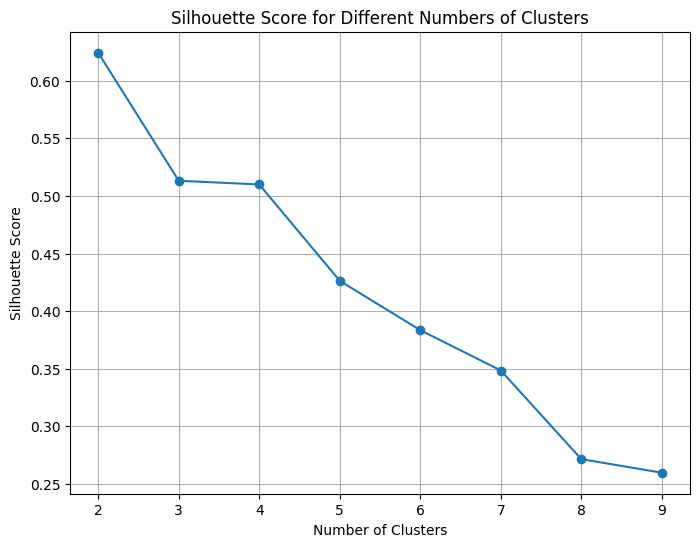

In [23]:
X = featured_df
n_clusters_range = range(2, 10)
sil_scores = []

for n_clusters in n_clusters_range:
    agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = agglomerative.fit_predict(X)
    sil_score = silhouette_score(X, cluster_labels)
    sil_scores.append(sil_score)

plt.figure(figsize=(8, 6))
plt.plot(n_clusters_range, sil_scores, marker='o')
plt.title("Silhouette Score for Different Numbers of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

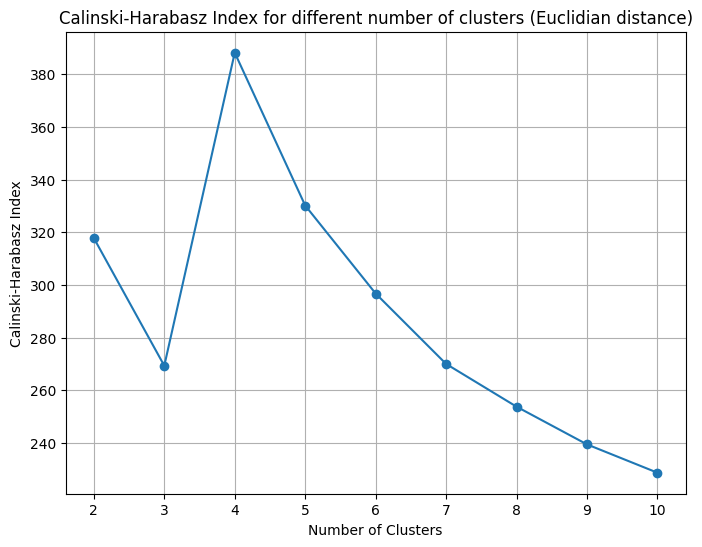

In [24]:
ch_scores = []
cluster_range = range(2, 11)

for n_clusters in cluster_range:
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    labels = agg_clustering.fit_predict(featured_df)
    ch_score = calinski_harabasz_score(featured_df, labels)
    ch_scores.append(ch_score)

plt.figure(figsize=(8, 6))
plt.plot(cluster_range, ch_scores, marker='o', linestyle='-')
plt.title('Calinski-Harabasz Index for different number of clusters (Euclidian distance)')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Index')
plt.grid(True)
plt.show()


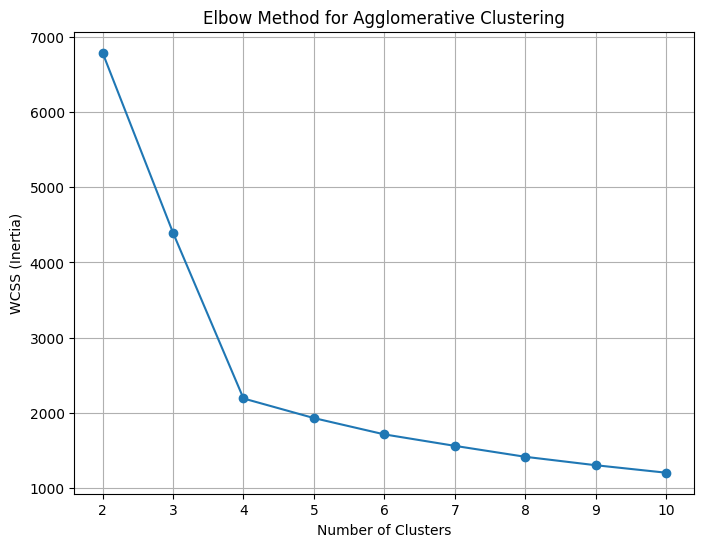

In [25]:
X = featured_df

def compute_inertia(X, labels, centroids):
    inertia = 0
    for i, centroid in enumerate(centroids):
        cluster_points = X[labels == i]
        distances = np.linalg.norm(cluster_points - centroid, axis=1)
        inertia += np.sum(distances ** 2)
    return inertia

inertias = []
range_n_clusters = range(2, 11)

for n_clusters in range_n_clusters:
    clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    labels = clustering.fit_predict(X)
    centroids = []
    for i in range(n_clusters):
        cluster_points = X[labels == i]
        centroids.append(np.mean(cluster_points, axis=0))
    centroids = np.vstack(centroids)
    inertia = compute_inertia(X, labels, centroids)
    inertias.append(inertia)


plt.figure(figsize=(8, 6))
plt.plot(range_n_clusters, inertias, marker='o')
plt.title('Elbow Method for Agglomerative Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Inertia)')
plt.grid(True)
plt.show()


**Agglomerative Hierarchical Clustering for 2 clusters**

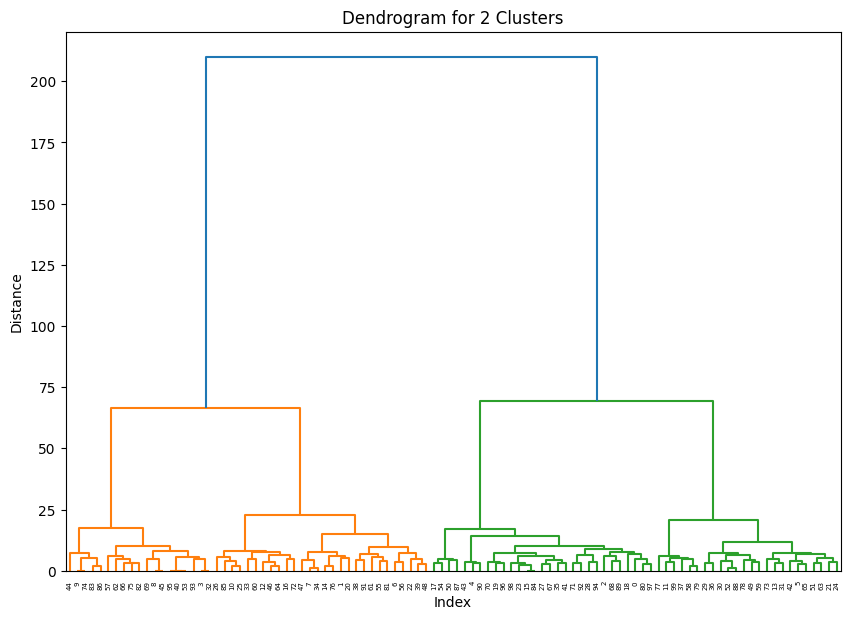

In [26]:
plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(sch.linkage(featured_df, method='ward'))
plt.title('Dendrogram for 2 Clusters')
plt.xlabel('Index')
plt.ylabel('Distance')
plt.show()

n_clusters = 2
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
cluster_labels = agg_clustering.fit_predict(featured_df)

**Agglomerative Hierarchical Clustering for 3 clusters**

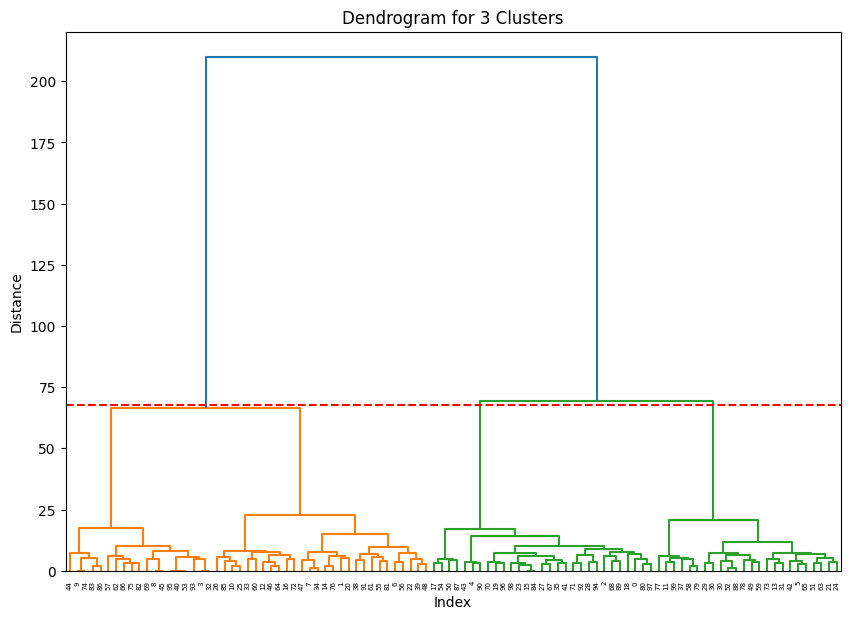

In [27]:
Z = sch.linkage(featured_df, method='ward')
# 'ward' minimizes variance within clusters

plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(Z)
n_clusters = 3
threshold = (Z[-n_clusters + 1, 2] + Z[-n_clusters, 2]) / 2
plt.axhline(y=threshold, color='r', linestyle='--')

plt.title(f'Dendrogram for {n_clusters} Clusters')
plt.xlabel('Index')
plt.ylabel('Distance')
plt.show()

agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
cluster_labels = agg_clustering.fit_predict(featured_df)


**Agglomerative Hierarchical Clustering for 4 clusters**

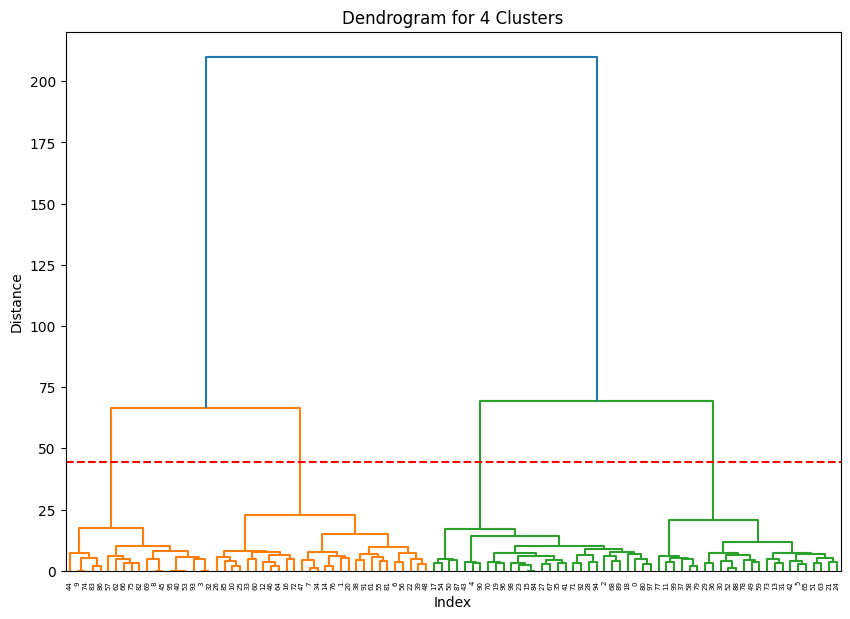

In [28]:
Z = sch.linkage(featured_df, method='ward')

plt.figure(figsize=(10, 7))
dendrogram = sch.dendrogram(Z)
n_clusters = 4
threshold = (Z[-n_clusters + 1, 2] + Z[-n_clusters, 2]) / 2
plt.axhline(y=threshold, color='r', linestyle='--')

plt.title(f'Dendrogram for {n_clusters} Clusters')
plt.xlabel('Index')
plt.ylabel('Distance')
plt.show()

agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
cluster_labels = agg_clustering.fit_predict(featured_df)

***Visualising the agglomerative hierarchical clustering (using Euclidean distance) results using t-SNE***

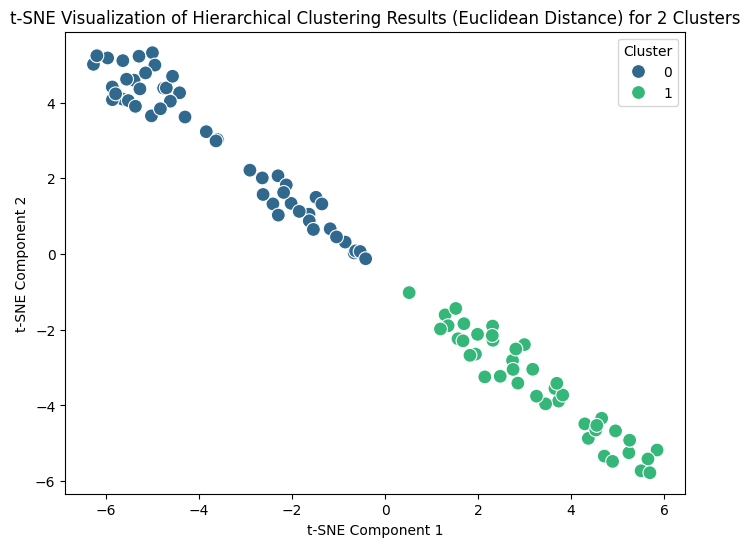

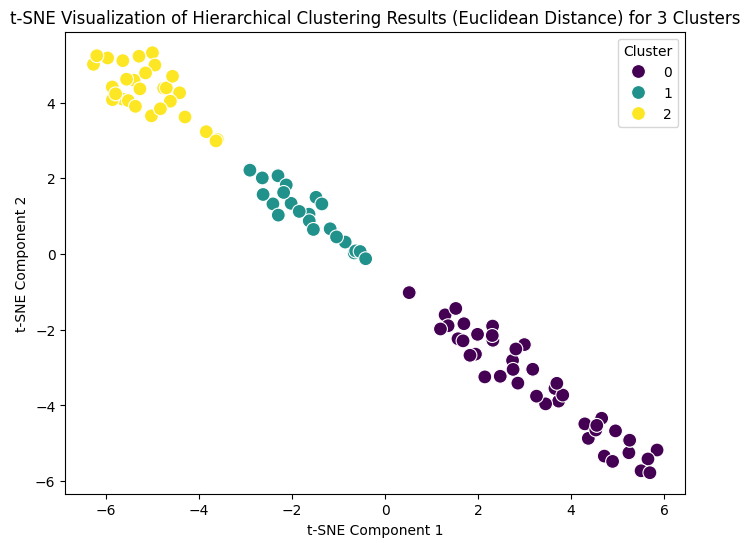

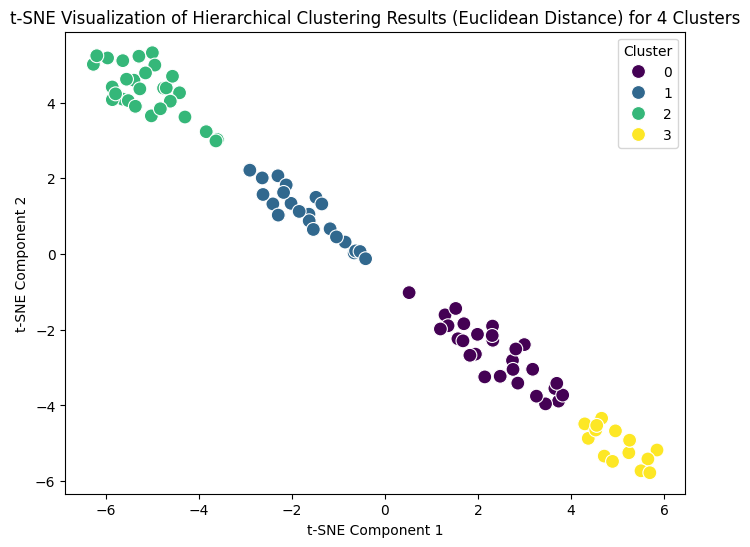

In [29]:
for n_clusters in range(2, 5):
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    cluster_labels = agg_clustering.fit_predict(featured_df)

    tsne = TSNE(n_components=2, random_state=42)
    tsne_components = tsne.fit_transform(featured_df)

    tsne_df = pd.DataFrame(data=tsne_components, columns=['tSNE1', 'tSNE2'])
    tsne_df['Cluster'] = cluster_labels

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='tSNE1', y='tSNE2', hue='Cluster', data=tsne_df, palette='viridis', s=100)
    plt.title(f't-SNE Visualization of Hierarchical Clustering Results (Euclidean Distance) for {n_clusters} Clusters')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(title='Cluster')
    plt.show()

***Finding the characteristics of each feature in each cluster: min, max, average, median***

In [30]:
binary_columns = [
    'skin_color_dark', 'skin_color_light', 'skin_color_medium',
    'lifestyle_career', 'lifestyle_family', 'lifestyle_sport', 'lifestyle_traveling',
    'occupation_employed', 'occupation_other', 'occupation_unemployed',
    'goal_comfortability', 'goal_confidence', 'goal_minimalism'
]

mean_std_values = df_encoded[binary_columns].agg(['mean', 'std'])

def unscale(scaled_value, column):
    return scaled_value * mean_std_values.loc['std', column] + mean_std_values.loc['mean', column]

new_df_unscaled = featured_df.copy()
for column in binary_columns:
    new_df_unscaled[column] = featured_df[column].apply(lambda x: unscale(x, column))

agglo_2 = AgglomerativeClustering(n_clusters=2)
agglo_3 = AgglomerativeClustering(n_clusters=3)
agglo_4 = AgglomerativeClustering(n_clusters=4)

new_df_unscaled['Agglo_Cluster_2'] = agglo_2.fit_predict(featured_df)
new_df_unscaled['Agglo_Cluster_3'] = agglo_3.fit_predict(featured_df)
new_df_unscaled['Agglo_Cluster_4'] = agglo_4.fit_predict(featured_df)

def compute_custom_cluster_stats(df, cluster_col):
    grouped = df.groupby(cluster_col)
    age_stats = grouped['age'].agg(['max', 'min', 'mean', 'median'])
    age_stats.columns = [f"age_{stat}" for stat in age_stats.columns]
    other_features = [col for col in df.columns if col not in ['age', cluster_col, 'Agglo_Cluster_2', 'Agglo_Cluster_3', 'Agglo_Cluster_4']]
    other_means = grouped[other_features].mean()
    other_means.columns = [f"{col}_mean" for col in other_means.columns]
    final_stats = pd.concat([age_stats, other_means], axis=1).reset_index()
    return final_stats

agglo_stats_2 = compute_custom_cluster_stats(new_df_unscaled, 'Agglo_Cluster_2')
agglo_stats_3 = compute_custom_cluster_stats(new_df_unscaled, 'Agglo_Cluster_3')
agglo_stats_4 = compute_custom_cluster_stats(new_df_unscaled, 'Agglo_Cluster_4')

print("\nAgglomerative Cluster Characteristics (2 clusters) - Unscaled Data:")
print(tabulate(agglo_stats_2, headers='keys', tablefmt='pretty'))

print("\nAgglomerative Cluster Characteristics (3 clusters) - Unscaled Data:")
print(tabulate(agglo_stats_3, headers='keys', tablefmt='pretty'))

print("\nAgglomerative Cluster Characteristics (4 clusters) - Unscaled Data:")
print(tabulate(agglo_stats_4, headers='keys', tablefmt='pretty'))



Agglomerative Cluster Characteristics (2 clusters) - Unscaled Data:
+---+-----------------+---------+---------+--------------------+------------+----------------------+-----------------------+------------------------+-----------------------+-----------------------+----------------------+--------------------------+--------------------------+-----------------------+----------------------------+--------------------------+----------------------+----------------------+
|   | Agglo_Cluster_2 | age_max | age_min |      age_mean      | age_median | skin_color_dark_mean | skin_color_light_mean | skin_color_medium_mean | lifestyle_career_mean | lifestyle_family_mean | lifestyle_sport_mean | lifestyle_traveling_mean | occupation_employed_mean | occupation_other_mean | occupation_unemployed_mean | goal_comfortability_mean | goal_confidence_mean | goal_minimalism_mean |
+---+-----------------+---------+---------+--------------------+------------+----------------------+-----------------------+-----

### **Spectral Hierarchical Clustering**

In [31]:
selected_feature_set = ['age', 'skin_color_dark', 'skin_color_light', 'skin_color_medium', 'lifestyle_career', 'lifestyle_family', 'lifestyle_sport', 'lifestyle_traveling', 'occupation_employed', 'occupation_other', 'occupation_unemployed', 'goal_comfortability', 'goal_confidence', 'goal_minimalism']
featured_df = df_scaled[selected_feature_set]
# featured_df

Silhouette Score

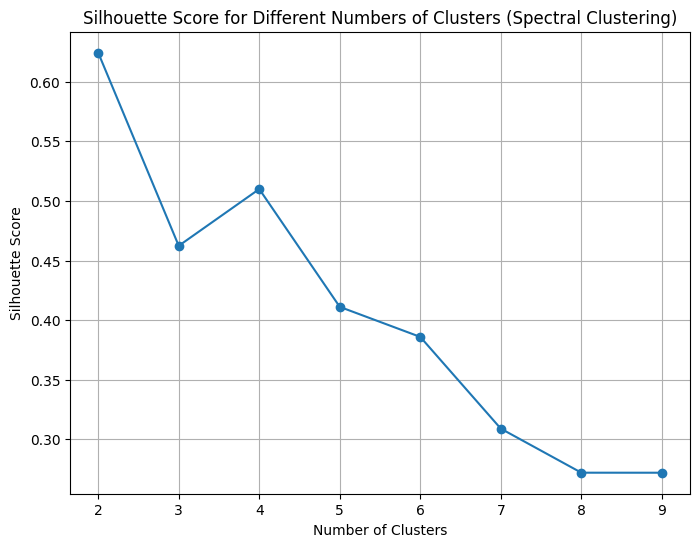

In [32]:
X = featured_df
cluster_range = range(2, 10)
sil_scores = []

for n_clusters in cluster_range:
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
    cluster_labels = spectral.fit_predict(X)
    sil_score = silhouette_score(X, cluster_labels)
    sil_scores.append(sil_score)

plt.figure(figsize=(8, 6))
plt.plot(cluster_range, sil_scores, marker='o')
plt.title("Silhouette Score for Different Numbers of Clusters (Spectral Clustering)")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()
# optimal_clusters = cluster_range[sil_scores.index(max(sil_scores))]

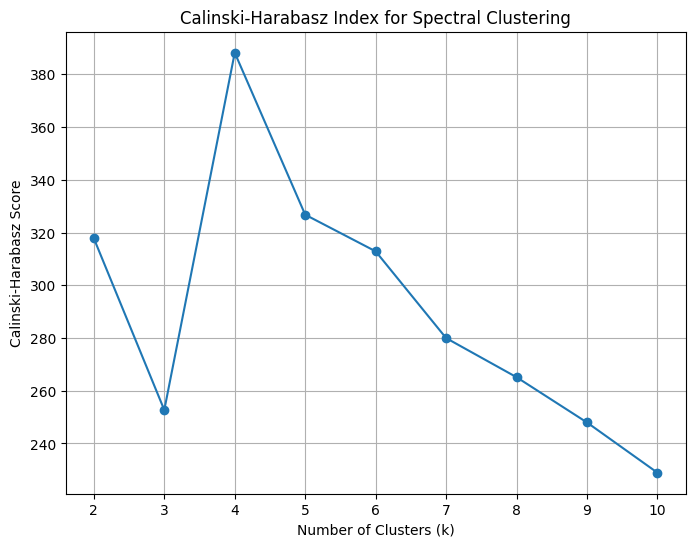

In [33]:
cluster_range = range(2, 11)
ch_scores = []

for k in cluster_range:
    spectral = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=42)
    labels = spectral.fit_predict(featured_df)
    score = calinski_harabasz_score(featured_df, labels)
    ch_scores.append(score)

plt.figure(figsize=(8, 6))
plt.plot(cluster_range, ch_scores, marker='o')
plt.title('Calinski-Harabasz Index for Spectral Clustering')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski-Harabasz Score')
plt.grid(True)
plt.show()


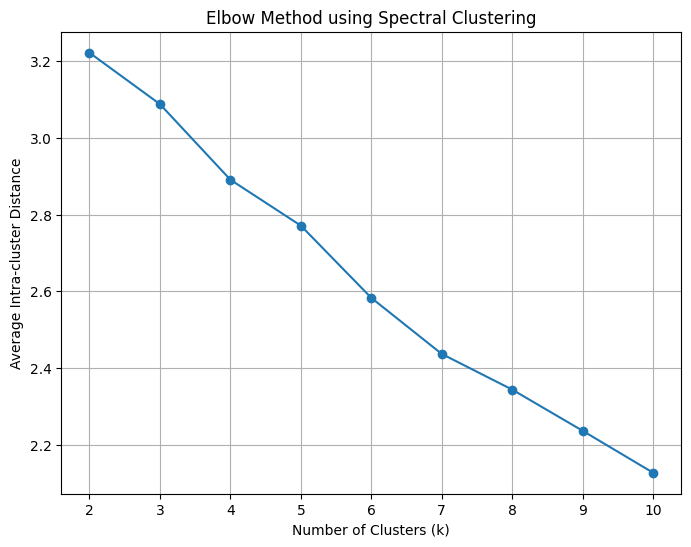

In [34]:
X = StandardScaler().fit_transform(featured_df)
cluster_range = range(2, 11)
avg_distances = []

for k in cluster_range:
    spectral = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=42)
    labels = spectral.fit_predict(X)
    distance_sum = 0
    for cluster_id in np.unique(labels):
        cluster_points = X[labels == cluster_id]
        centroid = cluster_points.mean(axis=0)
        distance_sum += np.sum(np.linalg.norm(cluster_points - centroid, axis=1))

    avg_distance = distance_sum / X.shape[0]
    avg_distances.append(avg_distance)

plt.figure(figsize=(8, 6))
plt.plot(cluster_range, avg_distances, marker='o')
plt.title('Elbow Method using Spectral Clustering')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Intra-cluster Distance')
plt.grid(True)
plt.show()

Performing Spectral Clustering and visualing results with PCA

<ipython-input-35-0bac13c5a2c6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  featured_df[f'Cluster_{n_clusters}'] = cluster_labels
<ipython-input-35-0bac13c5a2c6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  featured_df[f'Cluster_{n_clusters}'] = cluster_labels
<ipython-input-35-0bac13c5a2c6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

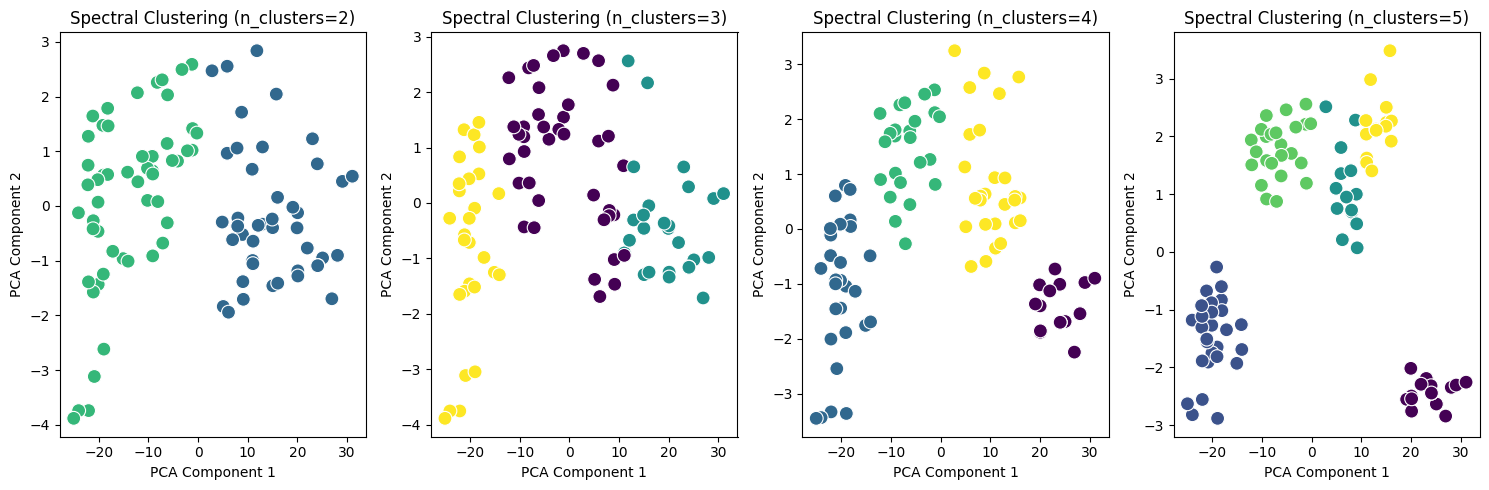

In [35]:
X = featured_df
cluster_counts = [2, 3, 4, 5]
plt.figure(figsize=(15, 5))

for i, n_clusters in enumerate(cluster_counts, 1):
    spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', assign_labels='kmeans', random_state=42)
    cluster_labels = spectral.fit_predict(X)
    featured_df[f'Cluster_{n_clusters}'] = cluster_labels
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    plt.subplot(1, 4, i)
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='viridis', s=100, legend=None)
    plt.title(f'Spectral Clustering (n_clusters={n_clusters})')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')

plt.tight_layout()
plt.show()

# for n_clusters in cluster_counts:
#     print(f"Cluster distribution for {n_clusters} clusters:")
#     print(featured_df[f'Cluster_{n_clusters}'].value_counts())
#     print("\n")

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


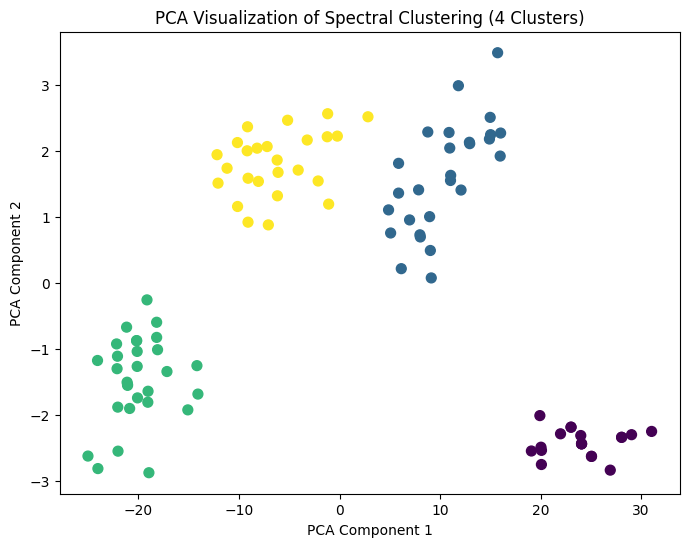

In [36]:
spectral = SpectralClustering(n_clusters=4, affinity='nearest_neighbors', random_state=42)
labels = spectral.fit_predict(featured_df)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(featured_df)

plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', s=50)
plt.title('PCA Visualization of Spectral Clustering (4 Clusters)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
# plt.grid(True)
plt.show()

Visualizing Spectral Clustering Results with t-SNE

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
<ipython-input-37-59d3b2c8b33e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  featured_df['Cluster'] = cluster_labels


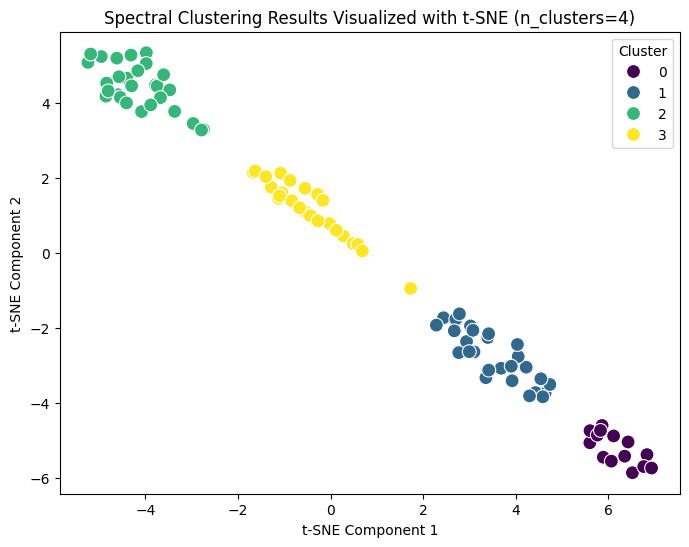

In [37]:
X = featured_df
n_clusters = 4
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', assign_labels='kmeans', random_state=42)
cluster_labels = spectral.fit_predict(X)
featured_df['Cluster'] = cluster_labels

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)
tsne_df = pd.DataFrame(data=X_tsne, columns=['tSNE1', 'tSNE2'])
tsne_df['Cluster'] = cluster_labels

plt.figure(figsize=(8, 6))
sns.scatterplot(x='tSNE1', y='tSNE2', hue='Cluster', data=tsne_df, palette='viridis', s=100)
plt.title(f'Spectral Clustering Results Visualized with t-SNE (n_clusters={n_clusters})')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.show()
# print(f"Cluster distribution:\n{df['Cluster'].value_counts()}")

In [38]:
binary_columns = [
    'skin_color_dark', 'skin_color_light', 'skin_color_medium',
    'lifestyle_career', 'lifestyle_family', 'lifestyle_sport', 'lifestyle_traveling',
    'occupation_employed', 'occupation_other', 'occupation_unemployed',
    'goal_comfortability', 'goal_confidence', 'goal_minimalism'
]

mean_std_values = df_encoded[binary_columns].agg(['mean', 'std'])

def unscale(scaled_value, column):
    return scaled_value * mean_std_values.loc['std', column] + mean_std_values.loc['mean', column]

new_df_unscaled = featured_df.copy()
for column in binary_columns:
    new_df_unscaled[column] = featured_df[column].apply(lambda x: unscale(x, column))

spectral_2 = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', assign_labels='kmeans', random_state=42)
spectral_3 = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', assign_labels='kmeans', random_state=42)
spectral_4 = SpectralClustering(n_clusters=4, affinity='nearest_neighbors', assign_labels='kmeans', random_state=42)
new_df_unscaled['Spectral_Cluster_2'] = spectral_2.fit_predict(featured_df)
new_df_unscaled['Spectral_Cluster_3'] = spectral_3.fit_predict(featured_df)
new_df_unscaled['Spectral_Cluster_4'] = spectral_4.fit_predict(featured_df)

def compute_custom_cluster_stats(df, cluster_col):
    grouped = df.groupby(cluster_col)
    age_stats = grouped['age'].agg(['max', 'min', 'mean', 'median'])
    age_stats.columns = [f"age_{stat}" for stat in age_stats.columns]
    other_features = [col for col in df.columns if col not in ['age', cluster_col, 'Spectral_Cluster_2', 'Spectral_Cluster_3', 'Spectral_Cluster_4']]
    other_means = grouped[other_features].mean()
    other_means.columns = [f"{col}_mean" for col in other_means.columns]
    final_stats = pd.concat([age_stats, other_means], axis=1).reset_index()
    return final_stats

spectral_stats_2 = compute_custom_cluster_stats(new_df_unscaled, 'Spectral_Cluster_2')
spectral_stats_3 = compute_custom_cluster_stats(new_df_unscaled, 'Spectral_Cluster_3')
spectral_stats_4 = compute_custom_cluster_stats(new_df_unscaled, 'Spectral_Cluster_4')

print("\nSpectral Cluster Characteristics (2 clusters) - Unscaled Data:")
print(tabulate(spectral_stats_2, headers='keys', tablefmt='pretty'))

print("\nSpectral Cluster Characteristics (3 clusters) - Unscaled Data:")
print(tabulate(spectral_stats_3, headers='keys', tablefmt='pretty'))

print("\nSpectral Cluster Characteristics (4 clusters) - Unscaled Data:")
print(tabulate(spectral_stats_4, headers='keys', tablefmt='pretty'))



Spectral Cluster Characteristics (2 clusters) - Unscaled Data:
+---+--------------------+---------+---------+-------------------+------------+----------------------+-----------------------+------------------------+-----------------------+-----------------------+----------------------+--------------------------+--------------------------+-----------------------+----------------------------+--------------------------+----------------------+------------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|   | Spectral_Cluster_2 | age_max | age_min |     age_mean      | age_median | skin_color_dark_mean | skin_color_light_mean | skin_color_medium_mean | lifestyle_career_mean | lifestyle_family_mean | lifestyle_sport_mean | lifestyle_traveling_mean | occupation_employed_mean | occupation_other_mean | occupation_unemployed_mean | goal_comfortability_mean | goal_confidence_mean |  goal_minimalism_mean  |  Cluster_2_mean   |   

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
